### **Preface:** The literature in this notebook chronicles my overall experience of understanding, implementing and testing BiDAF. It also shows how to run the program and some concluding remarks.

I had heard of BiDAF a couple of months ago when I was researching another QA system called [Dr.QA](https://github.com/facebookresearch/DrQA). While I only did some light reading on BiDAF at the time, I am glad that this assignment allowed me to implement and learn such an important and significant nlp model.

It took me roughly 5 days to complete this task. I spent the first 1.5 days trying to understand the code as it has been a long time since I have seen or written code like this. Nowadays I do most of my NLP research is done using Huggingface which abstracts away alot of the preprocessing and training pipelines. Nonetheless, it was worth tinkering around with the code as it gave me a much better understanding and a fairly low-level overview of the entire project. The next 2 days were spent training the model, as I was having issues with hardware. My PC has an nvidia 1050 TI graphics card however training times were too high and I was facing frequent system crashes. I therefore, had to use Google Colab or Kaggle. I used Google Colab in the end. On the first day of training I used both Colab free tier and I found Colab's resources to be significantly faster however, the free tier of Colab was still not enough! The first time I ran the training loop in Colab malfunctioned due to insufficient RAM and the training crashed after the 13/15 epoch. Below is an image of the training ouput from that day

![crash](crash.png)

When I tried to run the training loop again I found out that I had reached my daily quota and I was unable to use the GPUs for the rest of the day. I even tried the next day but my quota hadn't been reset yet even after 12 hours. I had no other option but to upgrade to Colab Pro and was finally able to successfully train, test and evaluate the model.

The final model was trained on the Squad V2 dataset with GloVe 100d embeddings with an `EM score` of `0.63` and an `F1 score` of `0.75`. So, it performed almost as well as the author's model. I did try to re-train the model using different hyperparameters such as reducing the `learning rate` from `0.5` to `0.1`, changing the `word embedding` and `character embedding` sizes to `200` and `16` respectively, however, not only did the training time increase by **x2.3** but the performance got worse. Below is an image of the training output of the first epoch with these hyperparameters.

![train2](train_2.png)

### Understanding BiDAF

- **BiDAF**\- Bi-Directional Attention Flow is a closed-domain QA system which requires a context and a query to answer questions about the context. It is an extractive QA model that can only answer factoid questions because extractive QA systems expect concise facts as answers.

- BiDAF mainly has 6 layers or simply 3 parts:
    - Embedding layers
    - Attention & modeling layers
    - Output layer


#### BiDAF embedding layer

In BiDAF, embedding is done on three levels of granularity: on the character, word and contextual levels.

Word embedding is done using GloVe. The output of word embedding is 2 matrices one for context and one for query. The dimensions of these matrices are **d1 x T** & **d1 x J** where **d1** is the vector dimension from GloVe and can be 50, 100, 300 or more and **T** and **J** are the number of words in the context and query respectively.

Character level embedding is done using a 1D-CNN. This is used to handle OOV words that GloVe initialized with random vectors. These random vectors can confuse the model if left unchecked therefore, we use the CNN to give parts of each word a vector representation. Each token from the context and the query passes through the CNN-layer similar to word embedding. The dimension of the context and query tokens are **d2 x T** and **d2 x J** where **d2** is the number of convolutional filters used in 1D-CNN. These 2 matrices will be concatenated with the matrices that we obtained from the word embedding step.

##### A highway network

After we obtain the matrices from the embedding layer and the char embedding layer the matrices are then *vertically concatenated*. This concatenation produces two matrices, one for the Context and the other for the Query. Their height is **d**, which is the sum of **d1** and **d2**. Meanwhile, their lengths are still the same as their predecessor matrices (**T** for the Context matrix and **J** for the Query matrix). This then becomes the input **y** which passes through the highway network. A highway network can be thought of as a FFNN but only a fraction of the input will be subjected to pass it. The remaining fraction is permitted to pass without being transformed. The ratio of these fractions is managed by **t**, the *transform gate* and by **(1-t)**, the *carry gate*. The value of **t** is calculated using a sigmoid function and is always between 0 and 1. The outputs of the highway network are again two matrices, one for the Context (a **d**-by-**T** matrix) and one for the Query (a **d**-by-**J** matrix). They represent the adjusted vector representations of words in the Query and the Context from word and character embedding steps.

##### Contextual Embedding

BiDAF requires an embedding mechanism that can understand a word in its context. This is where the contextual embedding layer comes in. The contextual embedding layer consists of Long-Short-Term-Memory (LSTM) sequences. BiDAF employs a bidirectional-LSTM (bi-LSTM), which is composed of both forward- as well as backward-LSTM sequences. The output of the contextual embedding step is two matrices — one from the Context and the other from the Query. These matrices are referred to as **H** and **U**. The Context matrix **H** is a **d**-by-**T** matrix while the Query matrix **U** is a **d**-by-**J** matrix.

#### BiDAF attention mechanism

The main goal of this layer is to fuse together information from **H** and **U** to create several matrix representations of context that also contain information from the query. The first attention related step is the formation of the so called similarity matrix **S**. **S** is a matrix with a dimension of **T**-by-**J** (number of words in context by the number of words in the query). It entails applying a comparison function to each column in **H** and each column in **U**.

##### Context-to-Query Attention(C2Q)

The goal of this layer is to find which query words are most relevant to each context words. C2Q is calculated similarly to how attention in seq2seq is calculated. First we use the scalar values in **S** to calculate the attention distribution. This is done by taking the row-wise softmax of **S**. The result is another matrix. Lets call this matrix **A**. This matrix, which has the same dimension as **S** indicates which query words are the most relevant to each context word. We then take every row of **A** to get the attention distribution **A_t** which has a dimension of **1-by-J**. **A_t:** reflects the relative importance of each query word for the t-th context word. We then calculate the weighted sum of the query matrix **U** with respect to each element in the attention distribution **A_t**. The result of this step is the attention output matrix called **Ũ**, which is a **2d**-by-**T** matrix. **Ũ** is just like **H**: a matrix representation of the context. However, **Ũ** contains different information from **H**. Whereas **H** encapsulates the semantic, syntactic and contextual meaning of each context word, **Ũ** encapsulates the information about the relevance of each query word to each context word.

##### Query-to-Context Attention(Q2C)

In this step, our goal is to find which Context word is most similar to either one of the Query words hence are critical for answering the Query. We first take the maximum row across of the similarity matrix **S** to get a column vector. This column vector is called **z**. The values in **z** serve as the attention values. We apply softmax on **z** to get an attention distribution called **b**. We then use **b** to take a weighted sum of the Context matrix **H**. The resulting attention output is a **2d-by-1** column vector called **ĥ**. The last step of Q2C is copying-and-pasting **ĥ** **T** times and combine these copies into a **2d-by-T** matrix called **Ĥ**. **Ĥ** is yet another representation of the Context that encapsulates the information about the most important words in the Context with respect to the Query.

##### Attention wrap up

The matrices produced in the steps above are then combined to form a giant matrix **G** with a dimension of **8d-by-T**. The giant matrix **G** contains all information in **H**, **Ũ** and **Ĥ**. This can be thought of as each column vector in **G** as a vector representation of a Context word that is “aware” of the existence of the Query and has incorporated relevant information from it.

#### Output Layer

**G** is then passed through what is known as a *modeling layer*. It consists of two layers of bi-LSTM and takes **G** as input. The first bi-LSTM layer converts **G** into **2d-by-T** matrix called **M1**. **M1** then acts as an input to the second bi-LSTM layer, which converts it to another **2d-by-T** matrix called **M2**. **M1** and **M2** are yet another matrix representation of Context words. The difference between **M1** and **M2** and the previous representations of Context words are that **M1** and **M2** have embedded in them information about the entire Context paragraph as well as the Query. For each word in the Context, we have two numeric vectors that encode the word’s relevance to the Query. The very last thing we need is to convert these numeric vectors to two probability values so that we can compare the Query-relevance of all Context words. And this is exactly what the output layer does. In the output layer, **M1** and **M2** are first vertically concatenated with **G** to form \[**G; M1**\] and \[**G; M2**\]. Both \[**G; M1**\] and \[**G; M2**\] have a dimension of **10d-by-T**.

We then obtain the probability distribution of the start and end indices over the entire Context.

Putting all of the above together, we get the following:
![bidaf](bidaf-architecture.png)

### File setup

In [1]:
!git clone https://gitlab.com/Pennywise881/question_answering_assignment_celloscope.git

Cloning into 'question_answering_assignment_celloscope'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 317 (delta 65), reused 0 (delta 0), pack-reused 176
Receiving objects: 100% (317/317), 290.47 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [2]:
%cd /content/question_answering_assignment_celloscope

/content/question_answering_assignment_celloscope


 ### In order to create the dataset `make_dataset.py` is run. Uncomment the next 2 cells if you want to create a dataset using a specific dimension based on `word_embedding_size` in `config.py` 

In [3]:
# !wget -nc -q {"https://nlp.stanford.edu/data/glove.6B.zip"}
# !unzip 'glove.6B.zip' -d 'glove_6B/'

In [4]:
# !pyton make_dataset.py

In [ ]:
!unzip 'squad.zip' -d 'Data/'
!unzip 'output.zip'

In [5]:
!pip install -r requirements.txt
!python -m spacy download en
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 14.6 MB/s 
     |████████████████████████████████| 209 kB 90.4 MB/s 
     |████████████████████████████████| 219 kB 69.1 MB/s 
     |████████████████████████████████| 178 kB 99.2 MB/s 
     |████████████████████████████████| 128 kB 89.1 MB/s 
     |████████████████████████████████| 156 kB 99.1 MB/s 
     |████████████████████████████████| 10.2 MB 58.1 MB/s 
     |████████████████████████████████| 132 kB 99.7 MB/s 
     |████████████████████████████████| 8.9 MB 55.2 MB/s 
     |████████████████████████████████| 357 kB 98.4 MB/s 
     |████████████████████████████████| 155 kB 78.8 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
     |████████████████████████████████| 81 kB 11.3 MB/s 
     |████████████████████████████████| 146 kB 91.4 MB/s 
     |█████████████████████████████

In [1]:
# external libraries
import numpy as np
import pickle
import os
import json
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

# internal utilities
import config
from model import BiDAF
from data_loader import SquadDataset
from utils import save_checkpoint, compute_batch_metrics, clean_text, word_tokenize, discretize

2022-07-08 14:45:58.091848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 14:45:58.091876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# preprocessing values used for training
prepro_params = {
    "max_words": config.max_words,
    "word_embedding_size": config.word_embedding_size,
    "char_embedding_size": config.char_embedding_size,
    "max_len_context": config.max_len_context,
    "max_len_question": config.max_len_question,
    "max_len_word": config.max_len_word
}

# hyper-parameters setup
hyper_params = {
    "num_epochs": config.num_epochs,
    "batch_size": config.batch_size,
    "learning_rate": config.learning_rate,
    "hidden_size": config.hidden_size,
    "char_channel_width": config.char_channel_width,
    "char_channel_size": config.char_channel_size,
    "drop_prob": config.drop_prob,
    "cuda": config.cuda,
    "pretrained": config.pretrained
}

experiment_params = {"preprocessing": prepro_params, "model": hyper_params}

# train on GPU if CUDA variable is set to True (a GPU with CUDA is needed to do so)
device = torch.device("cuda" if hyper_params["cuda"] else "cpu")
torch.manual_seed(42)

# define a path to save experiment logs
experiment_path = "output/{}".format(config.exp)
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

# save the preprocesisng and model parameters used for this training experiemnt
with open(os.path.join(experiment_path, "config_{}.json".format(config.exp)), "w") as f:
    json.dump(experiment_params, f)

# start TensorboardX writer
writer = SummaryWriter(experiment_path)

# load the embedding matrix created for our word vocabulary
with open(os.path.join(config.train_dir, "word_embeddings.pkl"), "rb") as e:
    word_embedding_matrix = pickle.load(e)
with open(os.path.join(config.train_dir, "char_embeddings.pkl"), "rb") as e:
    char_embedding_matrix = pickle.load(e)

# load mapping between words and idxs
with open(os.path.join(config.train_dir, "word2idx.pkl"), "rb") as f:
    word2idx = pickle.load(f)

idx2word = dict([(y, x) for x, y in word2idx.items()])

# transform them into Tensors
word_embedding_matrix = torch.from_numpy(np.array(word_embedding_matrix)).type(torch.float32)
char_embedding_matrix = torch.from_numpy(np.array(char_embedding_matrix)).type(torch.float32)

 ### One of the biggest problems that I faced was getting data from the data loader. There seemed to be a bug which was caused by empty labels being present in the `train` dataset. The code in the next cell filters out rows from any dataset that have empty labels i.e. the start and end positions 

In [3]:
def get_all_non_empty_data(word_context, char_context, word_question, char_question, labels):
    
    _labels = labels
    if type(_labels[0]) is np.str_:
        _labels = np.array([[int(a) for a in l.split("|")[0].split(" ")]
                                for l in _labels], dtype=np.int64)

    empty_label_indices = []
    
    for i in range(len(_labels)):
        if not len(list(_labels[i])):
            empty_label_indices.append(i)

    word_context = np.delete(word_context, empty_label_indices, 0)
    char_context = np.delete(char_context, empty_label_indices, 0)
    word_question = np.delete(word_question, empty_label_indices, 0)
    char_question = np.delete(char_question, empty_label_indices, 0)
    labels = np.delete(labels, empty_label_indices, 0)

    return word_context, char_context, word_question, char_question, labels                                                                                

### **Note:** Uncomment the next cell if you are **training**

In [ ]:
# # open features file and store them in individual variables (train + dev)
# train_features = np.load(os.path.join(config.train_dir, "train_features.npz"), allow_pickle=True)
# t_w_context, t_c_context, t_w_question, t_c_question, t_labels = train_features["context_idxs"],\
#                                                                  train_features["context_char_idxs"],\
#                                                                  train_features["question_idxs"],\
#                                                                  train_features["question_char_idxs"],\
#                                                                  train_features["label"]

In [4]:
dev_features = np.load(os.path.join(config.dev_dir, "dev_features.npz"), allow_pickle=True)
d_w_context, d_c_context, d_w_question, d_c_question, d_labels = dev_features["context_idxs"],\
                                                                 dev_features["context_char_idxs"],\
                                                                 dev_features["question_idxs"],\
                                                                 dev_features["question_char_idxs"],\
                                                                 dev_features["label"]

### **Note:** Uncomment the next cell if are **training**

In [ ]:
# train_dataset = SquadDataset(t_w_context, t_c_context, t_w_question, t_c_question, t_labels)
# valid_dataset = SquadDataset(d_w_context, d_c_context, d_w_question, d_c_question, d_labels)

# # # load data generators
# train_dataloader = DataLoader(train_dataset,
#                               shuffle=True,
#                               batch_size=hyper_params["batch_size"],
#                               num_workers=4)

# valid_dataloader = DataLoader(valid_dataset,
#                               shuffle=True,
#                               batch_size=hyper_params["batch_size"],
#                               num_workers=4)

# print("Length of training data loader is:", len(train_dataloader))
# print("Length of valid data loader is:", len(valid_dataloader))

In [5]:
# load the model
model = BiDAF(word_vectors=word_embedding_matrix,
              char_vectors=char_embedding_matrix,
              hidden_size=hyper_params["hidden_size"],
              drop_prob=hyper_params["drop_prob"])

### **Note:** Uncomment the next cell if you are **training**

In [ ]:
# if hyper_params["pretrained"]:
#     model.load_state_dict(torch.load(os.path.join(experiment_path, "model.pkl"))["state_dict"])
# model.to(device)

# # define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adadelta(model.parameters(), hyper_params["learning_rate"], weight_decay=1e-4)

# # best loss so far
# if hyper_params["pretrained"]:
#     best_valid_loss = torch.load(os.path.join(experiment_path, "model.pkl"))["best_valid_loss"]
#     epoch_checkpoint = torch.load(os.path.join(experiment_path, "model_last_checkpoint.pkl"))["epoch"]
#     print("Best validation loss obtained after {} epochs is: {}".format(epoch_checkpoint, best_valid_loss))
# else:
#     best_valid_loss = 100
#     epoch_checkpoint = 0

### **Note:** Comment out the next cell if you are **training**

In [6]:
# load dataset
test_dataset = SquadDataset(d_w_context, d_c_context, d_w_question, d_c_question, d_labels)

# load data generator
test_dataloader = DataLoader(test_dataset,
                             shuffle=True,
                             batch_size=hyper_params["batch_size"],
                             num_workers=4)

print("Length of test data loader is:", len(test_dataloader))

# # load the model
# model = BiDAF(word_vectors=word_embedding_matrix,
#               char_vectors=char_embedding_matrix,
#               hidden_size=hyper_params["hidden_size"],
#               drop_prob=hyper_params["drop_prob"])
try:
    if config.cuda:
        model.load_state_dict(torch.load(os.path.join(config.squad_models, "model.pkl"))["state_dict"])
    else:
        model.load_state_dict(torch.load(os.path.join(config.squad_models, "model.pkl"),
                                         map_location=lambda storage, loc: storage)["state_dict"])
    print("Model weights successfully loaded.")
except:
    print("Model weights not found, initialized model with random weights.")
model.to(device)

# define loss criterion
criterion = nn.CrossEntropyLoss()

Length of test data loader is: 92
Model weights successfully loaded.


### Training loop

In [ ]:
# # train the Model
# print("Starting training...")
# for epoch in tqdm(range(hyper_params["num_epochs"])):
#     # print("##### epoch {:2d}".format(epoch + 1))
#     model.train()
#     train_losses = 0
#     train_loop = tqdm(train_dataloader)
#     for batch in train_loop:
#         w_context, c_context, w_question, c_question, label1, label2 = batch[0].long().to(device),\
#                                                                        batch[1].long().to(device), \
#                                                                        batch[2].long().to(device), \
#                                                                        batch[3].long().to(device), \
#                                                                        batch[4][:, 0].long().to(device),\
#                                                                        batch[4][:, 1].long().to(device)
#         optimizer.zero_grad()
#         pred1, pred2 = model(w_context, c_context, w_question, c_question)
#         loss = criterion(pred1, label1) + criterion(pred2, label2)
#         train_losses += loss.item()

#         loss.backward()
#         optimizer.step()
#         train_loop.set_description(f'Epoch {epoch}')
#         train_loop.set_postfix(loss = loss.item())

#     writer.add_scalars("train", {"loss": np.round(train_losses / len(train_dataloader), 2),
#                                  "epoch": epoch + 1})
#     # print("Train loss of the model at epoch {} is: {}".format(epoch + 1, np.round(train_losses /len(train_dataloader), 2)))

#     model.eval()
#     valid_losses = 0
#     valid_em = 0
#     valid_f1 = 0
#     n_samples = 0
#     with torch.no_grad():
#         valid_loop = tqdm(valid_dataloader)
#         for batch in valid_loop:
#             w_context, c_context, w_question, c_question, labels = batch[0].long().to(device), \
#                                                                    batch[1].long().to(device), \
#                                                                    batch[2].long().to(device), \
#                                                                    batch[3].long().to(device), \
#                                                                    batch[4]

#             first_labels = torch.tensor([[int(a) for a in l.split("|")[0].split(" ")]
#                                          for l in labels], dtype=torch.int64).to(device)
#             pred1, pred2 = model(w_context, c_context, w_question, c_question)
#             loss = criterion(pred1, first_labels[:, 0]) + criterion(pred2, first_labels[:, 1])
#             valid_losses += loss.item()
#             em, f1 = compute_batch_metrics(w_context, idx2word, pred1, pred2, labels)
#             valid_em += em
#             valid_f1 += f1
#             n_samples += w_context.size(0)
#             valid_loop.set_description(f'Epoch {epoch}')
#             valid_loop.set_postfix(loss = loss.item())
#             # valid_loop.set_postfix("Valid EM of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_em / n_samples, 2)))
#             # valid_loop.set_postfix("Valid F1 of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_f1 / n_samples, 2)))

#         writer.add_scalars("valid", {"loss": np.round(valid_losses / len(valid_dataloader), 2),
#                                      "EM": np.round(valid_em / n_samples, 2),
#                                      "F1": np.round(valid_f1 / n_samples, 2),
#                                      "epoch": epoch + 1})
#         # print("Valid loss of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_losses /
#         #                                                                               len(valid_dataloader), 2)))
#         # print("Valid EM of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_em / n_samples, 2)))
#         # print("Valid F1 of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_f1 / n_samples, 2)))

#     # save last model weights
#     save_checkpoint({
#         "epoch": epoch + 1 + epoch_checkpoint,
#         "state_dict": model.state_dict(),
#         "best_valid_loss": np.round(valid_losses / len(valid_dataloader), 2)
#     }, True, os.path.join(experiment_path, "model_last_checkpoint.pkl"))

#     # save model with best validation error
#     is_best = bool(np.round(valid_losses / len(valid_dataloader), 2) < best_valid_loss)
#     best_valid_loss = min(np.round(valid_losses / len(valid_dataloader), 2), best_valid_loss)
#     save_checkpoint({
#         "epoch": epoch + 1 + epoch_checkpoint,
#         "state_dict": model.state_dict(),
#         "best_valid_loss": best_valid_loss
#     }, is_best, os.path.join(experiment_path, "model.pkl"))

# # export scalar data to JSON for external processing
# writer.export_scalars_to_json(os.path.join(experiment_path, "all_scalars.json"))
# writer.close()

Starting training...


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Saving a new best model.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Validation loss did not improve.


  0%|          | 0/1353 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

=> Saving a new best model.
=> Validation loss did not improve.


# Testing starts from here

In [7]:
model.eval()
test_em = 0
test_f1 = 0
n_samples = 0
with torch.no_grad():
    test_loop = tqdm(test_dataloader)
    for batch in test_loop:
        w_context, c_context, w_question, c_question, labels = batch[0].long().to(device),\
                                                                     batch[1].long().to(device),\
                                                                     batch[2].long().to(device),\
                                                                     batch[3].long().to(device),\
                                                                     batch[4]
        pred1, pred2 = model(w_context, c_context, w_question, c_question)
        em, f1 = compute_batch_metrics(w_context, idx2word, pred1, pred2, labels)
        test_em += em
        test_f1 += f1
        n_samples += w_context.size(0)
        

        # test_loop.set_description("Test EM of the model after training is: {}".format(np.round(test_em / n_samples, 2)))
        # test_loop.set_postfix(test_F1_score = np.round(test_f1 / n_samples, 2))
        # break
    writer.add_scalars("test", {"EM": np.round(test_em / n_samples, 2),
                                "F1": np.round(test_f1 / n_samples, 2)})
    print("Test EM of the model after training is: {}".format(np.round(test_em / n_samples, 2)))
    print("Test F1 of the model after training is: {}".format(np.round(test_f1 / n_samples, 2)))


  0%|          | 0/92 [00:00<?, ?it/s]

Test EM of the model after training is: 0.63
Test F1 of the model after training is: 0.74


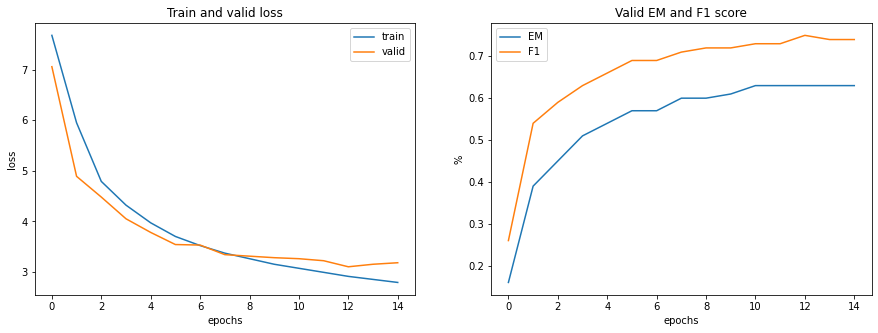

In [8]:
with open("./output/exp-1/all_scalars.json") as f:
    json_data = json.load(f)

epochs = [i for i in range(config.num_epochs)]
train_loss = [i[2] for i in json_data['output/exp-1/train/loss']]
valid_loss = [i[2] for i in json_data['output/exp-1/valid/loss']]
valid_em_scores = [i[2] for i in json_data['output/exp-1/valid/EM']]
valid_f1_scores = [i[2] for i in json_data['output/exp-1/valid/F1']]

fig, (ax1, ax2) = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
ax1.set_title("Train and valid loss")
ax1.plot(epochs, train_loss, label="train")
ax1.plot(epochs, valid_loss, label="valid")
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.set_title("Valid EM and F1 score")
ax2.plot(epochs, valid_em_scores, label="EM")
ax2.plot(epochs, valid_f1_scores, label="F1")
ax2.set_xlabel('epochs')
ax2.set_ylabel('%')
ax2.legend()

# Evaluating using custom data 

In [9]:
def eval(context, question):
    with open(os.path.join(config.data_dir, "train", "word2idx.pkl"), "rb") as wi, \
         open(os.path.join(config.data_dir, "train", "char2idx.pkl"), "rb") as ci, \
         open(os.path.join(config.data_dir, "train", "word_embeddings.pkl"), "rb") as wb, \
         open(os.path.join(config.data_dir, "train", "char_embeddings.pkl"), "rb") as cb:
        word2idx = pickle.load(wi)
        char2idx = pickle.load(ci)
        word_embedding_matrix = pickle.load(wb)
        char_embedding_matrix = pickle.load(cb)

    # transform them into Tensors
    word_embedding_matrix = torch.from_numpy(np.array(word_embedding_matrix)).type(torch.float32)
    char_embedding_matrix = torch.from_numpy(np.array(char_embedding_matrix)).type(torch.float32)
    idx2word = dict([(y, x) for x, y in word2idx.items()])

    context = clean_text(context)
    context = [w for w in word_tokenize(context) if w]

    question = clean_text(question)
    question = [w for w in word_tokenize(question) if w]

    if len(context) > config.max_len_context:
        print("The context is too long. Maximum accepted length is", config.max_len_context, "words.")
    if max([len(w) for w in context]) > config.max_len_word:
        print("Some words in the context are longer than", config.max_len_word, "characters.")
    if len(question) > config.max_len_question:
        print("The question is too long. Maximum accepted length is", config.max_len_question, "words.")
    if max([len(w) for w in question]) > config.max_len_word:
        print("Some words in the question are longer than", config.max_len_word, "characters.")
    if len(question) < 3:
        print("The question is too short. It needs to be at least a three words question.")

    context_idx = np.zeros([config.max_len_context], dtype=np.int32)
    question_idx = np.zeros([config.max_len_question], dtype=np.int32)
    context_char_idx = np.zeros([config.max_len_context, config.max_len_word], dtype=np.int32)
    question_char_idx = np.zeros([config.max_len_question, config.max_len_word], dtype=np.int32)

    # replace 0 values with word and char IDs
    for j, word in enumerate(context):
        if word in word2idx:
            context_idx[j] = word2idx[word]
        else:
            context_idx[j] = 1
        for k, char in enumerate(word):
            if char in char2idx:
                context_char_idx[j, k] = char2idx[char]
            else:
                context_char_idx[j, k] = 1

    for j, word in enumerate(question):
        if word in word2idx:
            question_idx[j] = word2idx[word]
        else:
            question_idx[j] = 1
        for k, char in enumerate(word):
            if char in char2idx:
                question_char_idx[j, k] = char2idx[char]
            else:
                question_char_idx[j, k] = 1

    with torch.no_grad():
        context_idx, context_char_idx, question_idx, question_char_idx = torch.tensor(context_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(context_char_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(question_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(question_char_idx, dtype=torch.int64).unsqueeze(0).to(device)

        pred1, pred2 = model(context_idx, context_char_idx, question_idx, question_char_idx)
        starts, ends = discretize(pred1.exp(), pred2.exp(), 15, False)
        prediction = " ".join(context[starts.item(): ends.item() + 1])

    return prediction

In [10]:
if __name__ == "__main__":
    context = '''
    Christopher Columbus, born between 25 August and 31 October 1451, died 20 May 1506 was an Italian
    explorer and navigator who completed four Spanish-based voyages across the Atlantic Ocean sponsored by the Catholic Monarchs
    of Spain, opening the way for the widespread European exploration and colonization of the Americas.
    His expeditions were the first known European contact with the Caribbean, Central America, and South America.
    Columbus made three further voyages to the Americas, exploring the Lesser Antilles in 1493, Trinidad and the northern coast 
    of South America in 1498, and the eastern coast of Central America in 1502. Many of the names he gave to geographical features, 
    particularly islands, are still in use. He also gave the name indios ("Indians") to the indigenous peoples he encountered. 
    The extent to which he was aware that the Americas were a wholly separate landmass is uncertain; 
    he never clearly renounced his belief that he had reached the Far East. 
    As a colonial governor, Columbus was accused by his contemporaries of significant brutality and was soon removed from the post. 
    Columbus's strained relationship with the Crown of Castile and its appointed colonial administrators in America led to his arrest and removal
    from Hispaniola in 1500, and later to protracted litigation over the perquisites that he and his heirs claimed were owed to them by the crown. 
    '''

    questions = ["When was Christopher Columbus born?", "How many voyages did Christopher Columbus complete?",
                 "When did Christopher Columbus die?",
                 "Who sponsored the voyages?"]

    print("C:", context, "\n")
    for q in questions:
        print("Q:", q)
        answer = eval(context, q)
        print("A:", answer, "\n")

C: 
    Christopher Columbus, born between 25 August and 31 October 1451, died 20 May 1506 was an Italian
    explorer and navigator who completed four Spanish-based voyages across the Atlantic Ocean sponsored by the Catholic Monarchs
    of Spain, opening the way for the widespread European exploration and colonization of the Americas.
    His expeditions were the first known European contact with the Caribbean, Central America, and South America.
    Columbus made three further voyages to the Americas, exploring the Lesser Antilles in 1493, Trinidad and the northern coast 
    of South America in 1498, and the eastern coast of Central America in 1502. Many of the names he gave to geographical features, 
    particularly islands, are still in use. He also gave the name indios ("Indians") to the indigenous peoples he encountered. 
    The extent to which he was aware that the Americas were a wholly separate landmass is uncertain; 
    he never clearly renounced his belief that he had r

# Conclusion

From the custom test data above we can see that the model does answer all but one question correctly. One of the trade offs of this model is that it has to have a fixed context length (in this case it is 400) therefore, setting a larger context throws an exception. This is one of the limitations of RNNs and it's variations. Increasing the context length could perhaps increase the performance however that would result in significantly longer training times and there is no guarantee that the model will perform just as well. The context length and the RNNs inability to hold on to information seen at a much later time step resulted in the creation of transformer based systems. 

Nowadays transformers are the norm for most nlp tasks. Transformer models can range from small to large with millions to billions of parameters however, smaller models such as `minilm` or `distill-bert` can and have outperformed BiDAF by orders of magnitude. Not to mention, modern QA systems have adopted the `retriever-reader` architecture also known as IR(Information Retrieval)-based QA. These models store 'documents' (i.e paragraphs or sentences from a corpus) and **retrieve** relevant documents to the query using `tf-idf` or `BM25`. A transformer-based model like `minilm` or `distill-bert` is then used which acts as the **reader** to find the start and end tokens from the the documents to create the answer span. Below is a high level overview of such an architecture.

![ir](retriever-reader.png) 

My area of research on nlp; specifically QA, has introduced me to the aforementioned architectures and models. I have been researching Huggingface transformers and using them for QA tasks for quite some time now. Needless to say, I will continue my research and I am currently working on a website that answer questions on wikipedia articles. The user simply has to provide the system with an entire wikipedia article and can ask factoid questions based on the article. Thank you for reading :)

In [ ]:
# from google.colab import files
# files.download('/content/question_answering_assignment_celloscope/output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !zip -r /content/question_answering_assignment_celloscope/Data.zip /content/question_answering_assignment_celloscope/Data
# from google.colab import files
# files.download('/content/question_answering_assignment_celloscope/Data.zip')